<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/multimodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multiple Model Option

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git
# Change directory into cloned repo
%cd MADSmilestone2

fatal: destination path 'MADSmilestone2' already exists and is not an empty directory.
/content/MADSmilestone2


In [3]:
!git pull

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/ian-byrne/MADSmilestone2
   29e4d56..3a3f93f  main       -> origin/main
Updating 29e4d56..3a3f93f
Fast-forward
 multimodel1.ipynb | 842 ++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 842 insertions(+)
 create mode 100644 multimodel1.ipynb


In [4]:
!pip install boto3

In [5]:
!ls

Data			 Loading	       Supervised
ian_testingground.ipynb  Model_Datasets.ipynb  Supervised_CNN.ipynb
ImagePlayground		 multimodel1.ipynb
Labeling		 README.md


In [6]:
# General Libraries
import pandas as pd
import numpy as np
import ast
# Custom Libraries
import Loading.load_data as ld

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# To Evaluate model
from tqdm import tqdm
# import torchmetrics
# from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [7]:
from botocore.exceptions import ClientError
from torch.nn.modules.activation import ReLU
# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
from torch.utils.data import Dataset, DataLoader
# import from module later
class ResizedClocks(Dataset):
    #Resized clock drawing dataset

    def __init__(self, round, round_labels):
        
       # Args:
           # round (int): Round to grab images from. 
           # values (list of tuples): Corresponding values for the round.
        
        self.round = round
        self.vals = round_labels
        self.client = boto3.client('s3', 
                                    aws_access_key_id=pubkey, 
                                    aws_secret_access_key=seckey)
    
    def __len__(self):
        return len(self.vals)

    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = self.vals[idx][1]
        bucket = "clockimages" #"test-bucket-clockids-aicrowd"
        obj_name = f"NHATS_R{self.round}_ClockDrawings/{spid}.tif" #f"{self.round}_{spid}.tif"
        #filename = str(spid)+".tif"
        temp = tempfile.NamedTemporaryFile()

        try:
          client.download_file(bucket, obj_name, temp.name)

          im = Image.open(temp.name)

          gray = im.convert('1')
          resized = gray.resize((160, 207)) 
          im_arr = np.array(resized).astype(int)

          sample = {'image': im_arr, 'label': label}
        
          temp.close()

          return sample
          
        except botocore.exceptions.ClientError as e:
          #logging.error(e)
          pass

In [9]:
file = open("Data/Dictionaries/score_dicts/tr_scor_dict_bal.txt", "r")

contents = file.read()
im_scores = ast.literal_eval(contents)

In [10]:
batch_size = 8
learning_rate = .001
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)

accuracy_stats = {
    'train': [],
    'val': []
}

loss_stats = {
    'train': [],
    'val': []
}

In [11]:
path = "/content/gdrive/MyDrive/numpy_files/Score_data/"
training_data, y_train_tensor = ld.load_np_files(path+"train_score_im.npy", path+"train_score_labels.npy")

(23621, 1, 368, 284)


In [12]:
validation_data, y_val_tensor = ld.load_np_files(path+"val_score_im.npy", path+"val_score_labels.npy")
test_data, y_test_tensor = ld.load_np_files(path+"tst_score_im.npy", path+"tst_score_labels.npy")

(2544, 1, 368, 284)
(2541, 1, 368, 284)


In [13]:
y_train_tensor = y_train_tensor.to(torch.long)
y_test_tensor = y_test_tensor.to(torch.long)
y_test_tensor = y_test_tensor.to(torch.long)

In [14]:
y_train_tensor.dtype

torch.int64

In [24]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)
#Labels 
#classes = (0.0, 1.0, 2.0, 3.0, 4.0, 5.0)
classes = (0, 1, 2, 3, 4, 5)

In [16]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640                        
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 32)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                     
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 64)
    self.bn2 = nn.BatchNorm2d(64) 

    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
    self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.pool3 = nn.MaxPool2d(2, 2) #Output shape = (None, 46, 35, 128)
    self.bn3 = nn.BatchNorm2d(128)
    
    # Fully connected layer
    self.fc1 = nn.Linear(128*46*35,6)
    #self.fc2 = nn.Linear(120, 60)
    #self.fc3 = nn.Linear(60, 30)
    #self.fc4 = nn.Linear(30, 3) # left with 3 for the three classes 

  def forward(self, x):
    x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
    x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = x.view(x.size(0),128*46*35)
    x = self.fc1(x)


    return x 

In [17]:
def accuracy(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_prob = torch.max(y_pred_softmax, dim = 1)
  
  #y_preds = y_pred.argmax(dim=1)

  correct_pred = (y_pred_prob == y_test).float()
  #print("correct sum: ", correct_pred.sum())
  #print('correct total length: ', len(correct_pred))
  #print(correct_pred)
  acc = correct_pred.sum() / len(correct_pred)
  
  #acc = correct_pred.sum().float() / float( y_test.size(0) )

  acc = torch.round(acc * 100)

  return acc

In [18]:
# Create model object 
model = ConvNet()
if torch.cuda.is_available():
    model = model.to(float).cuda()
    print('Model training on GPU')
else:
    print("CUDA is not available. Training on CPU...")

#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)

# Loss function
criterion = nn.CrossEntropyLoss(reduction="mean")

# Optimizer (can use SGD or ADAM)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9) #or ADAM/ momentum

print(model) 

Model training on GPU
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

In [25]:
def train_val_model(epochs):
  for epoch in range(1, epochs + 1):

    # TRAINING ********************************
    train_epoch_loss = 0
    train_epoch_acc = 0

    # set model in training mode (recommended)
    model.train()

    
    # Double check
    tr_run_loss=0
    tr_correct=0
    tr_total=0
    train_accu = []
    train_losses = []
    
    print('\nEpoch$ : %d'%epoch)
    for x_train_batch, y_train_batch in tqdm(train_loader):
        x_train_batch = x_train_batch.to(torch.double).to(device) # for GPU support
        y_train_batch = y_train_batch.to(torch.long).to(device) 

        #print(x_train_batch.shape)

        # sets gradients to 0 to prevent interference with previous epoch
        optimizer.zero_grad()

        # Forward pass through NN
        y_train_pred = model(x_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = accuracy(y_train_pred, y_train_batch)

        # Backward pass, updating weights
        train_loss.backward()
        optimizer.step()

        # Statistics
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

        # Double check scores
        tr_run_loss += train_loss.item()
        
        _, predicted = y_train_pred.max(1)
        tr_total += y_train_batch.size(0)
        tr_correct += predicted.eq(y_train_batch).sum().item()
       
    tr_loss = tr_run_loss/len(train_loader)
    accu = 100.*tr_correct/tr_total
   
    train_accu.append(accu)
    train_losses.append(tr_loss)
    print('Train Loss: %.3f | Train Accuracy: %.3f'%(tr_loss,accu))
    # VALIDATION****************************************   
    
    with torch.set_grad_enabled(False):
        val_epoch_loss = 0
        val_epoch_acc = 0

        # Double check
        val_run_loss=0
        val_correct=0
        val_total=0
        val_accu = []
        val_losses = []


        model.eval()
        for x_val_batch, y_val_batch in tqdm(validate_loader):
      
            x_val_batch =  x_val_batch.to(torch.double).to(device)
            y_val_batch = y_val_batch.to(torch.long).to(device)
                
            # Forward pass
            y_val_pred = model(x_val_batch)   
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = accuracy(y_val_pred, y_val_batch)
                
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

            # Double check
            
            val_run_loss += val_loss.item()
        
            _, predictedv = y_val_pred.max(1)
            val_total += y_train_batch.size(0)
            val_correct += predictedv.eq(y_val_batch).sum().item()
        
        vl_loss = val_run_loss/len(validate_loader)
        accuv = 100.*val_correct/val_total
    
        val_accu.append(accuv)
        val_losses.append(vl_loss)
        print('Validation Loss: %.3f | Validation Accuracy: %.3f'%(vl_loss,accuv))


    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(validate_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validate_loader))
                              
    
    print(f'Epoch {epoch+0:03}: Train Loss: {train_epoch_loss/len(train_loader):.5f} | \
    Val Loss: {val_epoch_loss/len(validate_loader):.5f}')

    print(f'Train Acc: {train_epoch_acc/len(train_loader):.3f} | \
    Val Acc: {val_epoch_acc/len(validate_loader):.3f}')

In [27]:
train_val_model(20)


Epoch$ : 1


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 552850610913439590773846930620416.000 | Train Accuracy: 16.807


100%|██████████| 318/318 [00:05<00:00, 54.70it/s]


Validation Loss: 2160178959221558136417687376440636473344.000 | Validation Accuracy: 19.057
Epoch 001: Train Loss: 552850610913439590773846930620416.00000 |     Val Loss: 2160178959221558136417687376440636473344.00000
Train Acc: 16.675 |     Val Acc: 11.755

Epoch$ : 2


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 575883748318565395032712136359936.000 | Train Accuracy: 16.735


100%|██████████| 318/318 [00:05<00:00, 54.62it/s]


Validation Loss: 1623635520435457961743123049687029907456.000 | Validation Accuracy: 19.057
Epoch 002: Train Loss: 575883748318565395032712136359936.00000 |     Val Loss: 1623635520435457961743123049687029907456.00000
Train Acc: 16.595 |     Val Acc: 11.733

Epoch$ : 3


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 586381131458722838094888996700160.000 | Train Accuracy: 16.625


100%|██████████| 318/318 [00:05<00:00, 54.44it/s]


Validation Loss: 2494177164681698320437323991115005689856.000 | Validation Accuracy: 5.094
Epoch 003: Train Loss: 586381131458722838094888996700160.00000 |     Val Loss: 2494177164681698320437323991115005689856.00000
Train Acc: 16.494 |     Val Acc: 3.066

Epoch$ : 4


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 580946251335354734404347954724864.000 | Train Accuracy: 16.761


100%|██████████| 318/318 [00:05<00:00, 54.55it/s]


Validation Loss: 396574384205919215124253654507315003392.000 | Validation Accuracy: 5.094
Epoch 004: Train Loss: 580946251335354734404347954724864.00000 |     Val Loss: 396574384205919215124253654507315003392.00000
Train Acc: 16.630 |     Val Acc: 3.085

Epoch$ : 5


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 552895786194343942094232779489280.000 | Train Accuracy: 16.244


100%|██████████| 318/318 [00:05<00:00, 54.52it/s]


Validation Loss: 700999347340773638507084526453805547520.000 | Validation Accuracy: 5.094
Epoch 005: Train Loss: 552895786194343942094232779489280.00000 |     Val Loss: 700999347340773638507084526453805547520.00000
Train Acc: 16.104 |     Val Acc: 3.082

Epoch$ : 6


100%|██████████| 2953/2953 [04:05<00:00, 12.02it/s]


Train Loss: 612470357480482723447353460654080.000 | Train Accuracy: 16.574


100%|██████████| 318/318 [00:05<00:00, 54.37it/s]


Validation Loss: 481262678154596885786022497990230409216.000 | Validation Accuracy: 5.094
Epoch 006: Train Loss: 612470357480482723447353460654080.00000 |     Val Loss: 481262678154596885786022497990230409216.00000
Train Acc: 16.442 |     Val Acc: 3.085

Epoch$ : 7


100%|██████████| 2953/2953 [04:05<00:00, 12.02it/s]


Train Loss: 477078166740170309933210888306688.000 | Train Accuracy: 16.909


100%|██████████| 318/318 [00:05<00:00, 54.34it/s]


Validation Loss: 2588136660027171974692897570264860065792.000 | Validation Accuracy: 5.094
Epoch 007: Train Loss: 477078166740170309933210888306688.00000 |     Val Loss: 2588136660027171974692897570264860065792.00000
Train Acc: 16.787 |     Val Acc: 3.097

Epoch$ : 8


100%|██████████| 2953/2953 [04:05<00:00, 12.02it/s]


Train Loss: 488212204909424889558253992673280.000 | Train Accuracy: 16.367


100%|██████████| 318/318 [00:05<00:00, 54.64it/s]


Validation Loss: 4468014679516538560378693217480249180160.000 | Validation Accuracy: 5.094
Epoch 008: Train Loss: 488212204909424889558253992673280.00000 |     Val Loss: 4468014679516538560378693217480249180160.00000
Train Acc: 16.231 |     Val Acc: 3.085

Epoch$ : 9


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 614624844526045551130350972829696.000 | Train Accuracy: 16.642


100%|██████████| 318/318 [00:05<00:00, 54.49it/s]


Validation Loss: 1844260897014536692583641276893953523712.000 | Validation Accuracy: 5.094
Epoch 009: Train Loss: 614624844526045551130350972829696.00000 |     Val Loss: 1844260897014536692583641276893953523712.00000
Train Acc: 16.512 |     Val Acc: 3.085

Epoch$ : 10


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 563087435341407409837638491832320.000 | Train Accuracy: 16.714


100%|██████████| 318/318 [00:05<00:00, 54.63it/s]


Validation Loss: 548441271189785120338861897230384627712.000 | Validation Accuracy: 5.094
Epoch 010: Train Loss: 563087435341407409837638491832320.00000 |     Val Loss: 548441271189785120338861897230384627712.00000
Train Acc: 16.576 |     Val Acc: 3.079

Epoch$ : 11


100%|██████████| 2953/2953 [04:05<00:00, 12.05it/s]


Train Loss: 643785278463564976959127963041792.000 | Train Accuracy: 16.739


100%|██████████| 318/318 [00:05<00:00, 54.57it/s]


Validation Loss: 12365310880001576820045916977919973916672.000 | Validation Accuracy: 5.094
Epoch 011: Train Loss: 643785278463564976959127963041792.00000 |     Val Loss: 12365310880001576820045916977919973916672.00000
Train Acc: 16.600 |     Val Acc: 3.088

Epoch$ : 12


100%|██████████| 2953/2953 [04:05<00:00, 12.05it/s]


Train Loss: 561602981420774411037067068833792.000 | Train Accuracy: 16.879


100%|██████████| 318/318 [00:05<00:00, 54.67it/s]


Validation Loss: 5183208425573568443394747328790785949696.000 | Validation Accuracy: 19.057
Epoch 012: Train Loss: 561602981420774411037067068833792.00000 |     Val Loss: 5183208425573568443394747328790785949696.00000
Train Acc: 16.745 |     Val Acc: 11.717

Epoch$ : 13


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 646129771962863406708620259229696.000 | Train Accuracy: 17.044


100%|██████████| 318/318 [00:05<00:00, 54.63it/s]


Validation Loss: 3354797756641554960648307461895929987072.000 | Validation Accuracy: 5.094
Epoch 013: Train Loss: 646129771962863406708620259229696.00000 |     Val Loss: 3354797756641554960648307461895929987072.00000
Train Acc: 16.920 |     Val Acc: 3.079

Epoch$ : 14


100%|██████████| 2953/2953 [04:05<00:00, 12.05it/s]


Train Loss: 600060146510060121723500897501184.000 | Train Accuracy: 16.291


100%|██████████| 318/318 [00:05<00:00, 54.67it/s]


Validation Loss: 1970478701018190989215637150282163421184.000 | Validation Accuracy: 5.094
Epoch 014: Train Loss: 600060146510060121723500897501184.00000 |     Val Loss: 1970478701018190989215637150282163421184.00000
Train Acc: 16.148 |     Val Acc: 3.101

Epoch$ : 15


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 591394744236569343267689092612096.000 | Train Accuracy: 16.511


100%|██████████| 318/318 [00:05<00:00, 54.64it/s]


Validation Loss: 326673849265417111770329228069503500288.000 | Validation Accuracy: 19.057
Epoch 015: Train Loss: 591394744236569343267689092612096.00000 |     Val Loss: 326673849265417111770329228069503500288.00000
Train Acc: 16.369 |     Val Acc: 11.745

Epoch$ : 16


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 485456600073759118304927367036928.000 | Train Accuracy: 16.731


100%|██████████| 318/318 [00:05<00:00, 54.64it/s]


Validation Loss: 1002124688565158625298601369849917603840.000 | Validation Accuracy: 5.094
Epoch 016: Train Loss: 485456600073759118304927367036928.00000 |     Val Loss: 1002124688565158625298601369849917603840.00000
Train Acc: 16.588 |     Val Acc: 3.075

Epoch$ : 17


100%|██████████| 2953/2953 [04:04<00:00, 12.06it/s]


Train Loss: 509017358427519252374896118857728.000 | Train Accuracy: 16.269


100%|██████████| 318/318 [00:05<00:00, 54.75it/s]


Validation Loss: 6952554037334427038426665438571546017792.000 | Validation Accuracy: 19.057
Epoch 017: Train Loss: 509017358427519252374896118857728.00000 |     Val Loss: 6952554037334427038426665438571546017792.00000
Train Acc: 16.144 |     Val Acc: 11.726

Epoch$ : 18


100%|██████████| 2953/2953 [04:05<00:00, 12.04it/s]


Train Loss: 511634718135699957929953625899008.000 | Train Accuracy: 16.142


100%|██████████| 318/318 [00:05<00:00, 54.16it/s]


Validation Loss: 1965921456002988109453964213671845429248.000 | Validation Accuracy: 5.094
Epoch 018: Train Loss: 511634718135699957929953625899008.00000 |     Val Loss: 1965921456002988109453964213671845429248.00000
Train Acc: 16.001 |     Val Acc: 3.082

Epoch$ : 19


100%|██████████| 2953/2953 [04:05<00:00, 12.03it/s]


Train Loss: 520077427832283934388977693360128.000 | Train Accuracy: 17.027


100%|██████████| 318/318 [00:05<00:00, 54.39it/s]


Validation Loss: 10720682704598965831227084816924301852672.000 | Validation Accuracy: 19.057
Epoch 019: Train Loss: 520077427832283934388977693360128.00000 |     Val Loss: 10720682704598965831227084816924301852672.00000
Train Acc: 16.896 |     Val Acc: 11.742

Epoch$ : 20


100%|██████████| 2953/2953 [04:05<00:00, 12.02it/s]


Train Loss: 573398343167253461229711885598720.000 | Train Accuracy: 16.790


100%|██████████| 318/318 [00:05<00:00, 54.48it/s]

Validation Loss: 1201267722444574419689619465981705322496.000 | Validation Accuracy: 5.094
Epoch 020: Train Loss: 573398343167253461229711885598720.00000 |     Val Loss: 1201267722444574419689619465981705322496.00000
Train Acc: 16.654 |     Val Acc: 3.101


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

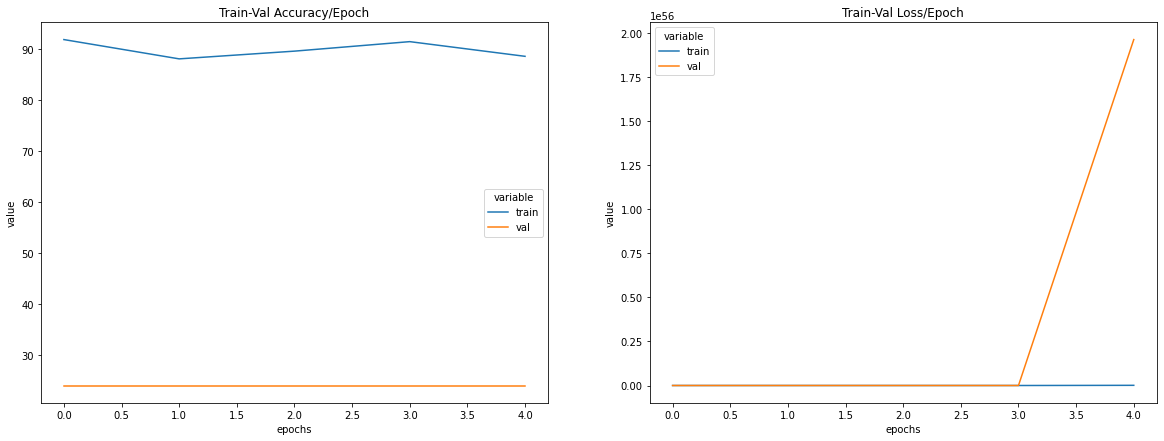

In [21]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# train_val_acc_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/acc.csv', index = False)
# train_val_loss_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/loss.csv', index = False)
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')